In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x


In [5]:
# Training the policy network
def train_policy_network(env, policy_net, optimizer, episodes=1000):
    all_rewards = []
    for episode in range(episodes):
        state = env.reset()[0]
        rewards = []
        log_probs = []
        for _ in range(100):  # limit the length of each episode
            state = torch.tensor(state, dtype=torch.float32)
            probs = policy_net(state)
            action = torch.multinomial(probs, 1).item()
            log_prob = torch.log(probs[action])
            next_state, reward, done, _,_ = env.step(action)
            rewards.append(reward)
            log_probs.append(log_prob)
            state = next_state
            if done:
                break

        # Calculate cumulative rewards and update policy network
        cumulative_rewards = np.cumsum(rewards[::-1])[::-1]
        loss = []
        for log_prob, reward in zip(log_probs, cumulative_rewards):
            loss.append(-log_prob * reward)
        optimizer.zero_grad()
        loss = torch.stack(loss).sum()
        loss.backward()
        optimizer.step()

        all_rewards.append(sum(rewards))
    return all_rewards


In [6]:
env = gym.make('CartPole-v1')
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
policy_net = PolicyNetwork(input_dim, output_dim)
optimizer = optim.Adam(policy_net.parameters(), lr=0.01)
rewards = train_policy_network(env, policy_net, optimizer)

/Users/vedantahazra/RL/rl_env/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [9]:
class GradientInversionAttack:
    def __init__(self, policy_net):
        self.policy_net = policy_net

    def reconstruct_state(self, gradients):
        reconstructed_states = []
        for grad in gradients:
            state_grad = grad['fc1.weight']
            reconstructed_state = self.invert_gradient(state_grad)
            reconstructed_states.append(reconstructed_state)
        return reconstructed_states

    def invert_gradient(self, grad):
        # Simplistic inversion for illustration purposes
        return grad.detach().numpy().flatten()

# Capture gradients and perform the attack
attack = GradientInversionAttack(policy_net)
gradients = []

def capture_gradients(policy_net, optimizer):
    for param in policy_net.parameters():
        if param.grad is not None:
            gradients.append({'fc1.weight': param.grad.clone()})

capture_gradients(policy_net, optimizer)
reconstructed_states = attack.reconstruct_state(gradients)


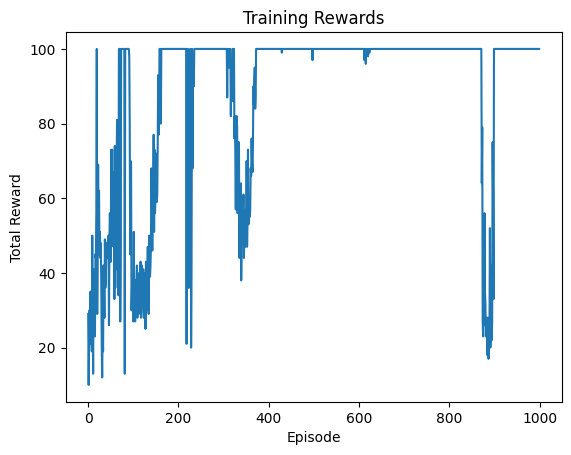

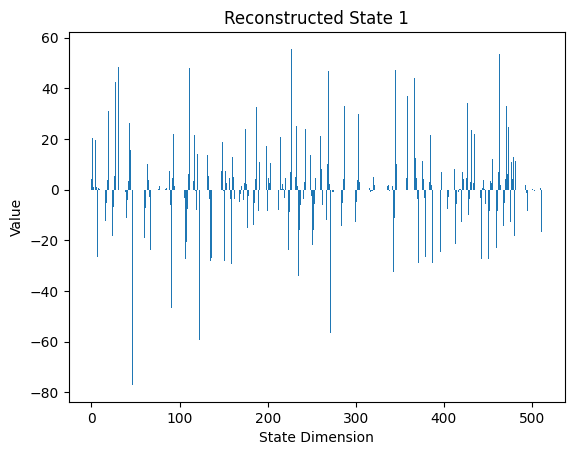

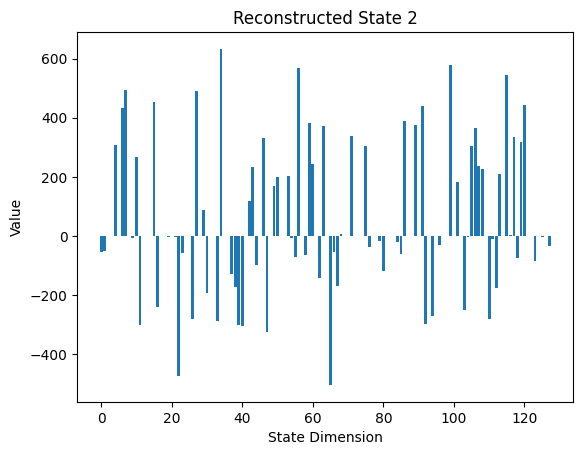

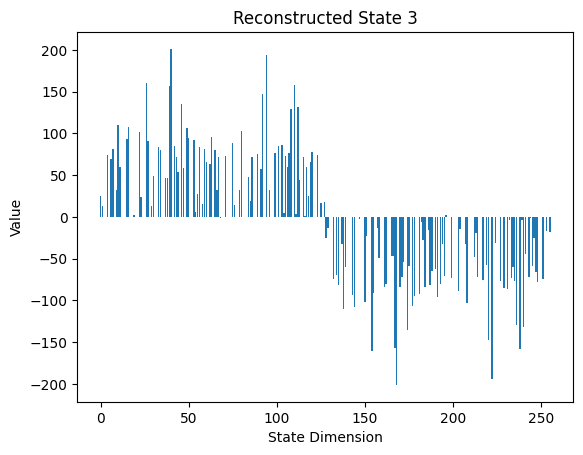

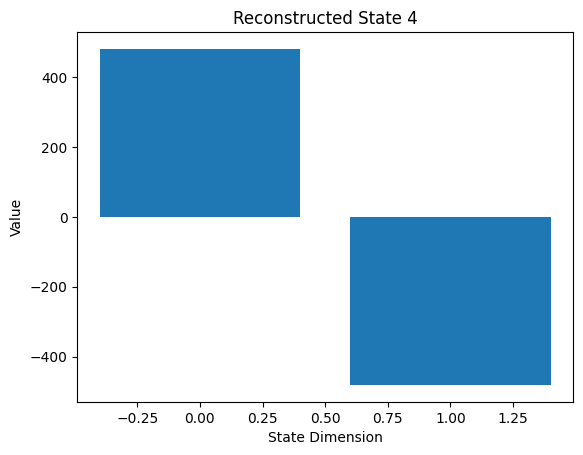

In [10]:
# Visualize the rewards
plt.figure()
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Rewards')
plt.show()

# Visualize the reconstructed states
def visualize_reconstructed_states(reconstructed_states):
    for i, state in enumerate(reconstructed_states):
        plt.figure()
        plt.bar(range(len(state)), state)
        plt.xlabel('State Dimension')
        plt.ylabel('Value')
        plt.title(f'Reconstructed State {i+1}')
        plt.show()

visualize_reconstructed_states(reconstructed_states)
